In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [2]:
import numpy as np
import torch, torchvision
from torchvision import transforms as tr
# from torch import nn
# from torch.nn import functional as F
import os
# import random
# import time
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns


import transformers


In [3]:
result_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/may14/'

In [4]:
def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[3]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
    
    if 'gr' in full_tag:
        return 'grgrgr'
    
    # single stage
    if full_tag=='g0':
        return 'g0g1g2'
    elif full_tag=='g3':
        return 'g3g1g2'
    elif full_tag=='g2':
        return 'g2g1g0'
    
    # 2 stage
    elif full_tag=='g0g1':
        return 'g0g1g2'
    elif full_tag=='g2g1':
        return 'g2g1g0'
    elif full_tag=='g2g2':
        return 'g2g2g2'
    elif full_tag=='g3g1':
        return 'g3g1g2'
    
    else:
        return full_tag
    

def edit_epoch(df, st):
    n_ep = 5
    iter_per_ep = 1000
    df['epoch'] += 1+(st-1)*n_ep
#     new_row = pd.DataFrame({'epoch': [0], 
#                         'train_loss': [1.15],
#                        'val_loss': [1.15]})
#     df = pd.concat([new_row, df]).reset_index(drop=True)
    df['iteration'] = iter_per_ep*df['epoch']
    
    return df

def add_tag(df, tag):
    df['curriculum'] = tag
    return df

In [5]:
tagname_dict = {'g0g1g2': 'Dev. (g0-g1-g2)', 
           'g2g1g0':'Anti-Dev. (g2-g1-g0)',
           'g3g1g2':'Adult (adult-g1-g2)',
           'g2g2g2':'Oldest Only (g2-g2-g2)',
           'grgrgr':'Random (rand-rand-rand)',
               'g0g0g0': 'Youngest Only (g0-g0-g0)'}
    
    
def proc_fp(fp, stage):
    df = pd.read_csv(fp).iloc[:,1:]
    df = edit_epoch(df, stage)
    tag = get_tag(fp)
    tag = tagname_dict[tag]
    df = add_tag(df, tag)
    return df

In [6]:
all_df = []

for stage in range(1,4):
    result_dir = result_root+'s'+str(stage)+'/'
    result_files = [result_dir+item
               for item in os.listdir(result_dir)
               if item.split('_')[0]=='train']
    for fp in result_files:
        df = proc_fp(fp, stage)
        all_df.append(df)

In [7]:
df_all = pd.concat(all_df)
df_all = df_all[['curriculum', 'epoch', 'iteration', 'train_loss', 'val_loss']]
df_all = df_all.rename(columns={
    'curriculum': 'Curriculum',
    'epoch': 'Epoch',
    'iteration': 'Iteration',
    'train_loss': 'Train Loss',
    'val_loss': 'Validation Loss'
})
df_all

,Curriculum,Epoch,Iteration,Train Loss,Validation Loss
0,Anti-Dev. (g2-g1-g0),1,1000,0.9963,0.9918
1,Anti-Dev. (g2-g1-g0),2,2000,0.9943,0.9916
2,Anti-Dev. (g2-g1-g0),3,3000,0.9942,0.9915
3,Anti-Dev. (g2-g1-g0),4,4000,0.9941,0.9916
4,Anti-Dev. (g2-g1-g0),5,5000,0.9941,0.9916
...,...,...,...,...,...
0,Dev. (g0-g1-g2),11,11000,0.9289,0.9187
1,Dev. (g0-g1-g2),12,12000,0.9187,0.9057
2,Dev. (g0-g1-g2),13,13000,0.9066,0.8946
3,Dev. (g0-g1-g2),14,14000,0.9004,0.8890


In [8]:
hue_order = ['Dev. (g0-g1-g2)',
            'Anti-Dev. (g2-g1-g0)',
            'Random (rand-rand-rand)',
            'Adult (adult-g1-g2)']

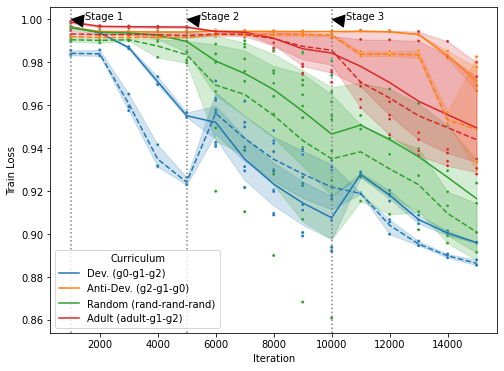

In [20]:
cdata = df_all[(df_all['Curriculum']!='Youngest Only (g0-g0-g0)') &
              (df_all['Curriculum']!='Oldest Only (g2-g2-g2)')]

fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=cdata, x='Iteration', y='Train Loss', hue='Curriculum', ax=ax,
            hue_order=hue_order)
sns.scatterplot(data=cdata, x='Iteration', y='Train Loss', hue='Curriculum', ax=ax, legend=False, s=10,
               hue_order=hue_order)
sns.lineplot(data=cdata, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False,
            hue_order=hue_order)
sns.scatterplot(data=cdata, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10,
               hue_order=hue_order)

ax.axvline(x=1000, color='gray', linestyle=':')
ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')


# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Stage 2', xy=(5000, 1), xytext=(5500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Stage 3', xy=(10000, 1), xytext=(10500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.savefig('fig_convergence.pdf', dpi=300)

In [11]:
result_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/may16/'

In [13]:
control_df = []

for stage in range(1,4):
    result_dir = result_root+'s'+str(stage)+'/'
    result_files = [result_dir+item
               for item in os.listdir(result_dir)
               if item.split('_')[0]=='train']
    for fp in result_files:
        df = proc_fp(fp, stage)
        control_df.append(df)

In [17]:
control_df = pd.concat(control_df)
control_df = control_df[['curriculum', 'epoch', 'iteration', 'train_loss', 'val_loss']]
control_df = control_df.rename(columns={
    'curriculum': 'Curriculum',
    'epoch': 'Epoch',
    'iteration': 'Iteration',
    'train_loss': 'Train Loss',
    'val_loss': 'Validation Loss'
})
control_df

,Curriculum,Epoch,Iteration,Train Loss,Validation Loss
0,Random (rand-rand-rand),1,1000,0.9959,0.9932
1,Random (rand-rand-rand),2,2000,0.9939,0.9905
2,Random (rand-rand-rand),3,3000,0.9936,0.9886
3,Random (rand-rand-rand),4,4000,0.9914,0.9726
4,Random (rand-rand-rand),5,5000,0.9746,0.9604
...,...,...,...,...,...
0,Random (rand-rand-rand),11,11000,0.9470,0.9689
1,Random (rand-rand-rand),12,12000,0.9268,0.9620
2,Random (rand-rand-rand),13,13000,0.9137,0.9548
3,Random (rand-rand-rand),14,14000,0.9037,0.9492


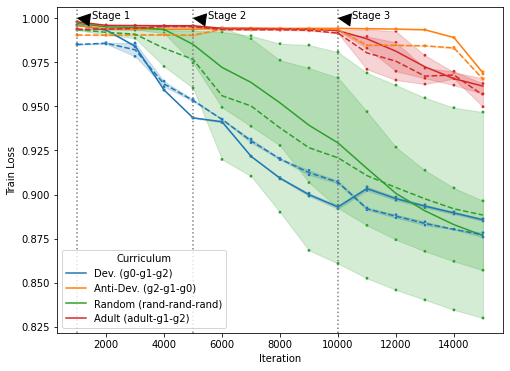

In [21]:
cdata = control_df[(control_df['Curriculum']!='Youngest Only (g0-g0-g0)') &
              (control_df['Curriculum']!='Oldest Only (g2-g2-g2)')]

fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=cdata, x='Iteration', y='Train Loss', hue='Curriculum', ax=ax,
            hue_order=hue_order)
sns.scatterplot(data=cdata, x='Iteration', y='Train Loss', hue='Curriculum', ax=ax, legend=False, s=10,
               hue_order=hue_order)
sns.lineplot(data=cdata, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False,
            hue_order=hue_order)
sns.scatterplot(data=cdata, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10,
               hue_order=hue_order)

ax.axvline(x=1000, color='gray', linestyle=':')
ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')


# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Stage 2', xy=(5000, 1), xytext=(5500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Stage 3', xy=(10000, 1), xytext=(10500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.savefig('fig_control.pdf', dpi=300)